# Data Challenge Stonne - Previsão de inadimplência

O objetivo desse notebook é estimar a probabilidade de um cliente não quitar um empréstimo antes do vencimento, e para gerar valor para o negócioo, queremos saber a probabilidade de default 90 dias após o desembolso do emprestimo.

> Requisitos

In [82]:
!pip install shap

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from sklearn.metrics import recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from datetime import datetime

%matplotlib inline
sns.set()

In [84]:
# Le o arquivo
path = '/content/drive/MyDrive/Ciência de Dados - Previsão de Inadimplência (Default)/dados_case_ds1-default/dados_case_ds1'

train_path = path + '/train.parquet'
test_path = path + '/test.parquet'

dataset = pd.read_parquet(train_path)

In [85]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2889113 entries, 3281 to 29337019
Data columns (total 14 columns):
 #   Column                        Dtype         
---  ------                        -----         
 0   id                            float64       
 1   desembolso                    datetime64[ns]
 2   vencimento                    datetime64[ns]
 3   valor_emprestado              float64       
 4   pgto_diario_esperado          float64       
 5   dia                           datetime64[ns]
 6   dias_pos_desembolso           float64       
 7   divida_total                  float64       
 8   divida_principal              float64       
 9   pagamento_diario              float64       
 10  amortizacao_principal_diario  float64       
 11  transacionado                 float64       
 12  subsegmento                   object        
 13  y                             float64       
dtypes: datetime64[ns](3), float64(10), object(1)
memory usage: 330.6+ MB


In [86]:
dataset.head()

,id,desembolso,vencimento,valor_emprestado,pgto_diario_esperado,dia,dias_pos_desembolso,divida_total,divida_principal,pagamento_diario,amortizacao_principal_diario,transacionado,subsegmento,y
3281,6.0,2019-03-25,2019-12-26,7100.0,33.7107,2019-03-25,0.0,7197.98,7100.0,0.00,0.0,664.0,None,0.0
3282,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-26,1.0,7212.25,7100.0,0.00,0.0,0.0,None,0.0
3283,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-27,2.0,7226.54,7100.0,0.00,0.0,150.0,None,0.0
3284,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-28,3.0,7207.22,7100.0,33.64,0.0,0.0,None,0.0
3285,6.0,2019-03-25,2019-12-26,7100.0,33.8852,2019-03-29,4.0,7221.51,7100.0,0.00,0.0,0.0,None,0.0


Como queremos prever se a probabilidade do cliente não pagar o empréstimo no dia 90 do contrato, vamos usar apenas os dados até 90 dias após o desembolso. E para separar nossos dados em treino e teste vamos utilizar a data do desembolso do crédito já que, caso o modelo esteja com uma boa performance, podemos aplicá-lo para os próximos clientes que fizerem empréstimo.

In [87]:
train_raw = dataset[ (dataset['desembolso'] <= '2020-04-15') & (dataset['dias_pos_desembolso'] <= 90)]
test_raw = dataset[ (dataset['desembolso'] > '2020-04-15') & (dataset['dias_pos_desembolso'] <= 90)]

Vamos utilizar os clientes que fizeram um empréstimos até o dia 15 de abril de 2020 para treinar o modelo, todos que tem data de desembolso após a esta, usaremos para testar nosso modelo. 

Para uma abordagem futura, serie bastante interessante verificar o quanto manter dados amsi antigos degradam o modelo, e assim, decidir qual seria a data de desembolso mais antiga que deveria ser incluida no modelo.



## Análise Exploratória

### Os dados estão balanceados?

In [88]:
train_raw.groupby(['id'])['y'].mean().value_counts()

0.0    11359
1.0      754
Name: y, dtype: int64

In [89]:
train_raw.groupby(['id'])['y'].mean().value_counts(normalize=True)

0.0    0.937753
1.0    0.062247
Name: y, dtype: float64

Os dados não estáo balanceados, temos muito mais clientes que quitam sua dívida. E, será necessário uma abordagem que lide com isso. 

### Existem clientes que quitaram o empréstimo antes dos primeiros 90 dias de contrato?

In [90]:
df =  train_raw.groupby(['id','y']).agg({
        'valor_emprestado':'first',
        'divida_total':'last'
    }).sort_values(by='divida_total')


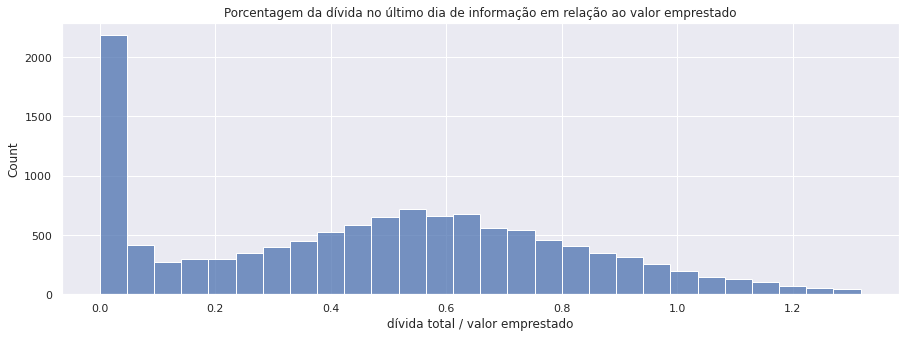

In [91]:
fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(df['divida_total']/df['valor_emprestado'])

plt.title('Porcentagem da dívida no último dia de informação em relação ao valor emprestado')
plt.xlabel('dívida total / valor emprestado')
plt.show()

Podemos observar que mesmo durante os primeiros 90 dias de contrato, já temos clientes que quitaram toda a dívida ou boa parte dela.

In [92]:
df = train_raw.groupby(['id', 'y','desembolso']).agg({
    'dias_pos_desembolso':'max',
    'valor_emprestado':'first',
    'divida_total':'last'
}).sort_values(by='desembolso')

df.head()

,,,dias_pos_desembolso,valor_emprestado,divida_total
id,y,desembolso,,,
442.0,0.0,2019-02-28,90.0,10200.0,6823.71
12.0,0.0,2019-03-06,90.0,7700.0,2879.13
78.0,0.0,2019-03-08,90.0,5400.0,3307.90
134.0,1.0,2019-03-11,90.0,9900.0,11248.24
145.0,0.0,2019-03-11,90.0,12500.0,8445.70


In [93]:
def plot_over_time(col):

  to_plot = ( df.assign(per=lambda x: x[col]/x['valor_emprestado'])
                .groupby(['dias_pos_desembolso','y'])['per']
                .agg(['mean', 'std', 'count'])
                .replace(np.nan, 0)
                .reset_index(1))

  fig, ax = plt.subplots(figsize=(15,5))

  sns.lineplot(data=to_plot, x='dias_pos_desembolso', y='mean')
  plt.title(f'Média da razão entre {col} e valor emprestado por dias de desembolso')

  plt.ylabel(f'Média {col} / valor emprestado')
  plt.legend()
  plt.show()

No handles with labels found to put in legend.


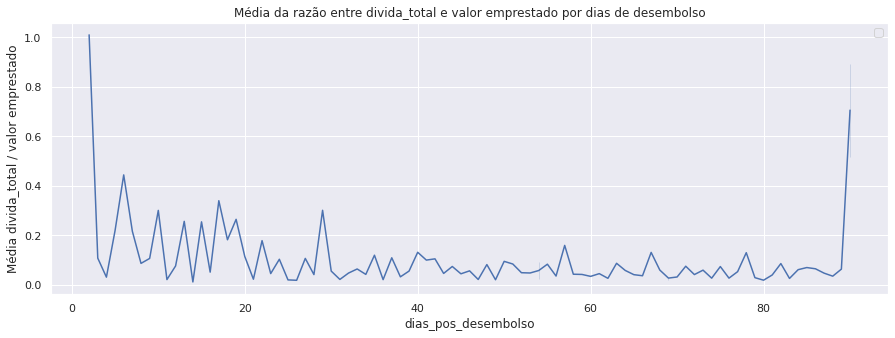

In [94]:
plot_over_time('divida_total')

Nos primeiros dias após o desembolso é esperado que o cliente tenha a divida muito próximo ao valor emprestado, já que ele ainda não teve tempo para pagar, mas conforme os dias após o desembolso se passam, a dívida está diminuindo.

Já no pico próximo ao dia 90 do desembolso indica que existem clientes que ainda não quitaram boa parte do empréstimo. O que nos gera algumas dúvidas:

- Nesse perído de tempo, o valor emprestado é menor que a divida?

- O cliente que não irá quitar o empréstimo está pagando alguma quantia mínima?

In [95]:
((df['divida_total'] - df['valor_emprestado']) / df['valor_emprestado']).describe()

count    12113.000000
mean        -0.529397
std          0.330130
min         -0.999978
25%         -0.834798
50%         -0.507666
75%         -0.289807
max          0.317384
dtype: float64

No geral, a dívida total está diminuindo. Vamos verificar apenas nos clientes que não quitaram a dívida.

In [96]:
df_1 = df.loc[ (slice(None), 1), :]

((df_1['divida_total'] - df_1['valor_emprestado']) / df_1['valor_emprestado']).describe()

count    754.000000
mean      -0.109343
std        0.249904
min       -0.979968
25%       -0.263578
50%       -0.088301
75%        0.076424
max        0.317380
dtype: float64

Dentre os clientes inadimplentes, a dívida também diminui em alguns caso, mas com uma intensidade menor do que  contexto geral.

### Qual o pagamento diário médio em relação ao valor emprestado?

In [97]:
df = train_raw.groupby(['id','y']) \
              .agg({
                  'pagamento_diario':['sum'],
                  'valor_emprestado':'first'})

to_plot = pd.DataFrame()

to_plot['mean_pgto_diario'] = df['pagamento_diario']['sum'] / df['valor_emprestado']['first']

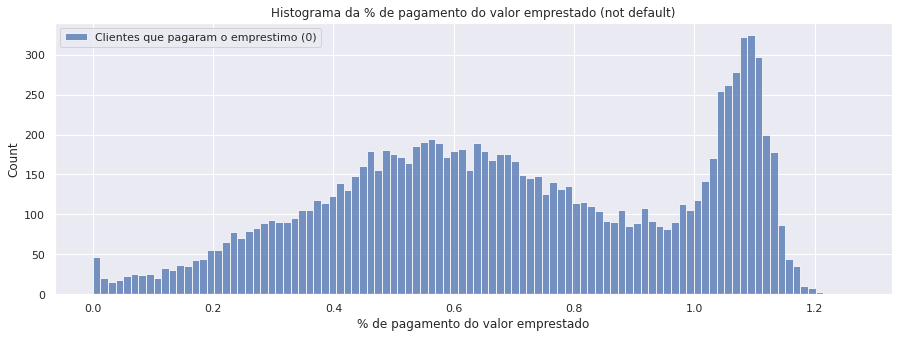

In [98]:
to_plot_0 = to_plot.loc[ (slice(None), 0), : ]

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=to_plot_0, x='mean_pgto_diario', bins=100, label='Clientes que pagaram o emprestimo (0)')

plt.title('Histograma da % de pagamento do valor emprestado (not default)')
plt.xlabel('% de pagamento do valor emprestado')
plt.legend()
plt.show()

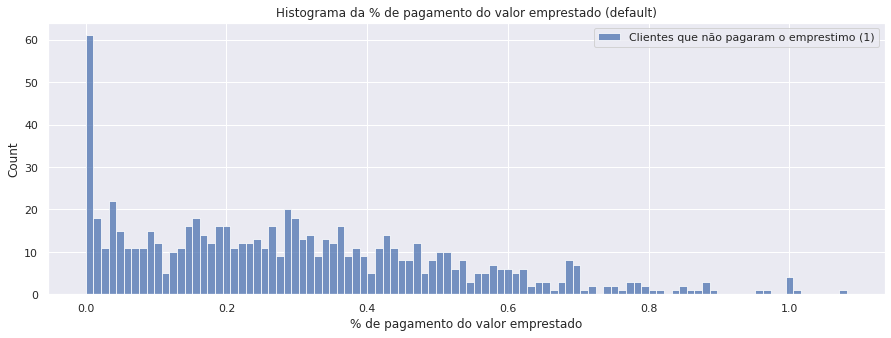

In [99]:
to_plot_1 = to_plot.loc[ (slice(None), 1), : ]

fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(data=to_plot_1, x='mean_pgto_diario', bins=100, label='Clientes que não pagaram o emprestimo (1)')

plt.title('Histograma da % de pagamento do valor emprestado (default)')
plt.xlabel('% de pagamento do valor emprestado')
plt.legend()
plt.show()

O comportamento do pagamento médio dos clientes que não quitaram é bastante diferente e como esperado eles quitam uma parcela pequena da dívida, exceto alguns outiliers que  podemos observar que pagou um valor próximo ao valor emprestado, mas entreou em defaul por não ter pago a divida total com os juros aplicados.

### Qual a quantidade de clientes inadimplentes ao longo do tempo?

Primeiro vamos observar a quantidade de clientes ao longo do tempo.

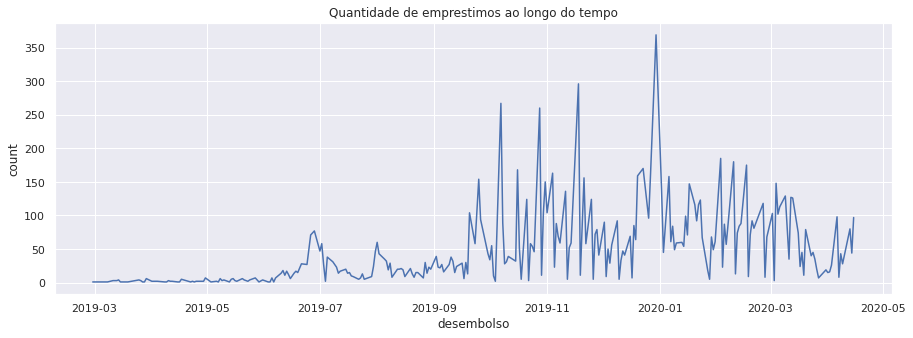

In [100]:
df = ( train_raw.groupby(['id','y'])
                .agg({'desembolso':'first'})
                .assign(count=lambda x: 1)
                .groupby('desembolso')
                .count())


fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=df, x='desembolso', y='count')

plt.title('Quantidade de emprestimos ao longo do tempo')
plt.show()

Podemos observar um pico de contratações no início do ano de 2020, e poucas contratação anteiores à agosto de 2019. 
E como a quantidade de desembolsos ao longo do tempo muda bastante, vamos verificar a porcentagem de default ao longo do tempo.

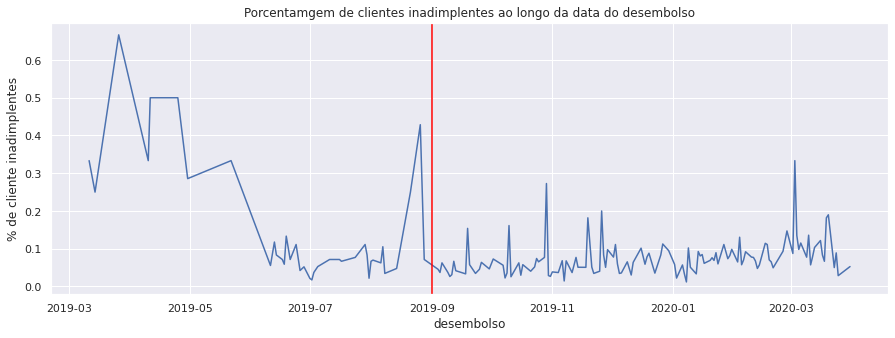

In [101]:
df_1 = ( train_raw.groupby(['id','y'])
                .agg({'desembolso':'first'})
                .assign(count=lambda x: 1)
                .loc[ (slice(None), 1), :]
                .groupby('desembolso')
                .count())

df_percent_default = df_1 / df

fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(data=df_percent_default, x='desembolso', y='count')
plt.axvline(datetime(2019, 9, 1), color='red')

plt.title('Porcentamgem de clientes inadimplentes ao longo da data do desembolso')
plt.ylabel('% de cliente inadimplentes')
plt.show()

Como temos poucos dados antes de agosto de 2019, faz sentido olharmos a porcentagem após este perído, e o dados continuam desbalanceados. 

### Qual o tempo médio de contrato das duas classes?

In [102]:
df = train_raw.groupby('id') \
              .agg({'desembolso':'first','vencimento':'first', 'y':'max'})

df['tempo_contrato'] = (df['vencimento'] - df['desembolso']).dt.days

In [103]:
df['tempo_contrato'][ df['y'] == 0 ].describe()

count    11359.000000
mean       286.471256
std         47.216762
min        251.000000
25%        270.000000
50%        272.000000
75%        273.000000
max        548.000000
Name: tempo_contrato, dtype: float64

In [104]:
df['tempo_contrato'][ df['y'] == 1 ].describe()

count    754.000000
mean     281.251989
std       29.020671
min      263.000000
25%      270.000000
50%      271.000000
75%      273.000000
max      364.000000
Name: tempo_contrato, dtype: float64

No geral, o tempo de contrato é bem parecido nas duas classes.

## Feature Engineering

In [105]:
def feature_engineering(raw):

  slices = ['0-90','0-30', '30-60', '60-90']

  col_names = pd.Series([
                'desembolso',
                'vencimento',
                'valor_emprestado',
                'mean_pgto_diario_esperado',
                'std_pgto_diario_esperado',
                'max_dia',
                'max_dias_pos_desembolso',
                'last_divida_total',
                'mean_divida_total',
                'last_divida_principal',
                'mean_divida_principal',
                'sum_pagamento_diario',
                'mean_pagamento_diario',
                'std_pagameto_diario',
                '%_sem_pagamento_diario',
                'mean_amortizacao_principal_diario',
                'std_amortizacao_principal_diario',
                'sum_transacionado',
                'mean_transacionado',
                'std_transacionado',
                '%_dia_sem_transacao',
                'label_y',
                'percent_pgto_do_emprest',
                'subsegmento'
    ])
  

  all_names = pd.Series([])
  index = []

  # Colunas que não mudam ao longo do tempo
  fixed_col = pd.Series(['desembolso', 'vencimento', 'valor_emprestado', 'label_y'])
  cols_to_drop = pd.Series([])
  
  for sl in slices:

    min, max = sl.split('-')
    cond = (raw['dias_pos_desembolso'] >= int(min) ) & (raw['dias_pos_desembolso'] <= int(max))
    df_raw = raw[ cond ]

    new_names = col_names[:24].apply(lambda x: x + '_' + sl)
    all_names = pd.concat([all_names, new_names])

    df = df_raw.groupby('id').agg({
        'desembolso':'first',
        'vencimento':'first',
        'valor_emprestado':'first',
        'pgto_diario_esperado':['mean', 'std'],
        'dia':'max',
        'dias_pos_desembolso':'max',
        'divida_total':['last','mean'],
        'divida_principal':['last','mean'],
        'pagamento_diario':['sum', 'mean', 'std', lambda x: (x == 0).sum()/x.count()],
        'amortizacao_principal_diario':['mean', 'std'],
        'transacionado':['sum','mean', 'std', lambda x: (x == 0).sum()/x.count()],
        'y':'max'
    })

    # Agrupa o subsegmento
    seg = ( df_raw.replace(np.nan, 'NaN') # Substituindo nan por string para aplicar mode()
                  .groupby('id')['subsegmento']
                  .apply(lambda x: x.mode())
                  .values )
    
    # df auxiliar para calcular a % de pagamento do emprestimo
    df_aux = (df_raw.groupby('id')
                    .agg({'pagamento_diario':'sum', 'valor_emprestado':'first'}))


    df = (df.assign(percent_pgto_do_emprest=df_aux['pagamento_diario'] / df_aux['valor_emprestado'])
            .assign(subsegmento=seg))
    

    if sl == '0-90':
      index = df.index
      dfs = df.copy()
      
    
    else: 
      dfs = pd.concat([dfs, df], axis=1)

      col_slice = fixed_col.apply(lambda x: x + '_' + sl )
      cols_to_drop = pd.concat([cols_to_drop, col_slice])


  dataset = pd.DataFrame(dfs.values, columns=all_names, index=index)

  # Quando temos informação de um dia apenas vamos considerar como std = 0
  cols_std = dataset.columns[ all_names.apply(lambda x: x[:3]) == 'std' ]
  dataset[cols_std] = dataset[cols_std].replace(np.nan, 0)

  # dropar columnas iguais (subsegmento, desembolso, vencimento, label)
  dataset.drop(columns=cols_to_drop, inplace=True)


  return dataset



In [106]:
def preprocessing(df):

  X = pd.DataFrame()
  y = df.loc[:,'label_y_0-90'].values.astype('int')

  df.drop(columns=['label_y_0-90'], inplace=True)

  columns_date = df.columns

  for col in columns_date:

    column = df[col]

    if column.dtype == 'datetime64[ns]':

      #X['year_' + col] = column.dt.year
      X['month_' + col] = column.dt.month
      #X['day_' + col] = column.dt.day

    elif col in  ['subsegmento_0-90', 'subsegmento_0-30', 'subsegmento_30-60', 'subsegmento_60-90']:
      pass
    
    else:
      X[col] = column

  X.replace(np.nan, 0, inplace=True)

  return X.astype('float'), y

In [107]:
df = feature_engineering(train_raw)
X_train, y_train = preprocessing(df)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [108]:
df = feature_engineering(test_raw)
X_test, y_test = preprocessing(df)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


## Melhor modelo

Para escolher o melhor modelo, utilizaremos uma validação cruzada com a separação dos folds estratificada, ou seja, mantendo a distribuição das classes nos dados na separação dos dados.

Testaremos os seguintes modelos:

- Logistic Regression
- Random Forest
- XGBoost

In [109]:
results_auc = pd.DataFrame()
results_recall = pd.DataFrame()

In [110]:
scaled_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

pipe_LR_cv = Pipeline([('Scaler', StandardScaler()),
                       ('Logistic Regression', LogisticRegression(class_weight='balanced'))])

models = [
          ('Logistic Regression', pipe_LR_cv),
          ('Random Forest', RandomForestClassifier(class_weight='balanced')),
          ('XGBoost', XGBClassifier(scaled_pos_weight=scaled_pos_weight))
          ]

for name, model in models:

  kfold = StratifiedKFold(n_splits=10, random_state=31, shuffle=True)

  results_auc[name] = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc', verbose=0)
  results_recall[name] = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall', verbose=0)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

In [111]:
results_auc.describe()

,Logistic Regression,Random Forest,XGBoost
count,10.000000,10.000000,10.000000
mean,0.895731,0.875713,0.896334
std,0.017525,0.023776,0.012633
min,0.851279,0.831661,0.870153
25%,0.896482,0.865153,0.889733
50%,0.901319,0.882604,0.902613
75%,0.905044,0.893327,0.903923
max,0.910270,0.899489,0.908845


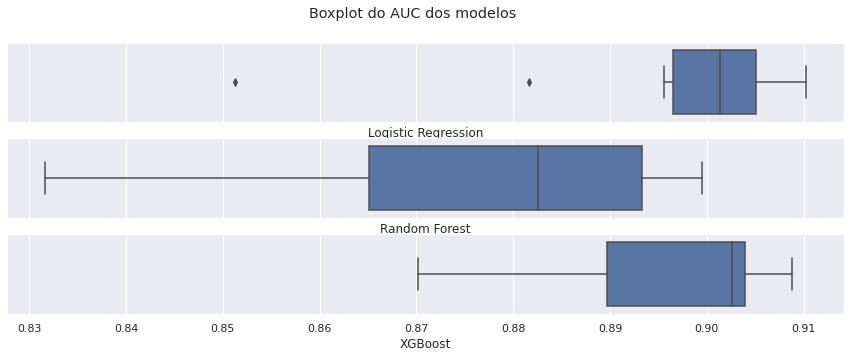

In [112]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('Boxplot do AUC dos modelos')

sns.boxplot(ax=axes[0], x=results_auc['Logistic Regression'])
sns.boxplot(ax=axes[1], x=results_auc['Random Forest'])
sns.boxplot(ax=axes[2], x=results_auc['XGBoost'])


In [113]:
results_recall.describe()

,Logistic Regression,Random Forest,XGBoost
count,10.000000,10.000000,10.000000
mean,0.808860,0.173702,0.183000
std,0.048911,0.032023,0.035201
min,0.706667,0.120000,0.120000
25%,0.793333,0.158421,0.171053
50%,0.821228,0.178772,0.178772
75%,0.842105,0.194079,0.200000
max,0.855263,0.226667,0.240000


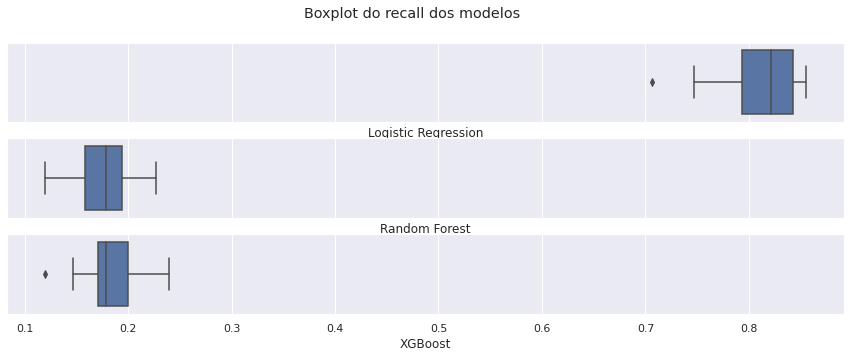

In [114]:
fig, axes = plt.subplots(3, 1, figsize=(15, 5), sharey=True, sharex=True)
fig.suptitle('Boxplot do recall dos modelos')

sns.boxplot(ax=axes[0], x=results_recall['Logistic Regression'])
sns.boxplot(ax=axes[1], x=results_recall['Random Forest'])
sns.boxplot(ax=axes[2], x=results_recall['XGBoost'])

A regressão logistica teve resultados muito bons, tanto para AUC que o geral teve bons resultados, quanto para o recall, e a escolheremos como modelo para o nosso objetivo.

In [115]:
pipe_LR_cv.fit(X_train, y_train)

y_pred = pipe_LR_cv.predict(X_test)
y_prob = pipe_LR_cv.predict_proba(X_test)[:,1]

print('Logistic Regression\n')
print('ROC_AUC prob ', roc_auc_score(y_test, y_prob))
print('ROC_AUC pred ', roc_auc_score(y_test, y_pred))
print('Recall ', recall_score(y_test, y_pred))

Logistic Regression

ROC_AUC prob  0.968509542977628
ROC_AUC pred  0.8083942605219201
Recall  0.6428571428571429


lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




> Os modelos foram testados com um balanceamento no peso das classes, e para passos futuros poderiamos testar alguns métodos para lidar com dados desbalanceados, como undersampling ou oversampling. 

## Feature selection

Selecionar as melhores features pode diminuir a complexidade do modelo, e impede que ele degrade ao longo do tempo.

In [116]:
pipe_LR_fs = Pipeline([('Scaler', StandardScaler()),
                       ('Logistic Regression', LogisticRegression(class_weight='balanced'))])

pipe_LR_fs.fit(X_train, y_train)

importance = pd.DataFrame({
    'Features':X_train.columns,
    'Coefs':pipe_LR_fs['Logistic Regression'].coef_[0]}).sort_values(by='Coefs', ascending=False)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Vamos verificar quais variáveis são menos importantes para o modelo, retiralas e testar o modelo para verificar se a performance se manteve.

In [117]:
tolerance = 2e-2
importance[ np.abs(importance['Coefs']) <= tolerance ]

,Features,Coefs
49,sum_pagamento_diario_30-60,0.006504
61,std_pgto_diario_esperado_60-90,0.000000
42,std_pgto_diario_esperado_30-60,0.000000
16,std_amortizacao_principal_diario_0-90,-0.010451


In [118]:
importance[ np.abs(importance['Coefs']) >= tolerance ]

,Features,Coefs
6,max_dias_pos_desembolso_0-90,2.372431
14,%_sem_pagamento_diario_0-90,1.566358
23,std_pgto_diario_esperado_0-30,1.535408
66,last_divida_principal_60-90,1.438143
4,std_pgto_diario_esperado_0-90,1.256012
...,...,...
51,std_pagameto_diario_30-60,-0.974924
58,%_dia_sem_transacao_30-60,-1.080772
8,mean_divida_total_0-90,-1.249287
65,mean_divida_total_60-90,-1.265035


Logo, as variáveis mais importantes são:

In [119]:
important_features = importance[ np.abs( importance['Coefs'] ) >= tolerance ]['Features'].values
important_features

array(['max_dias_pos_desembolso_0-90', '%_sem_pagamento_diario_0-90',
       'std_pgto_diario_esperado_0-30', 'last_divida_principal_60-90',
       'std_pgto_diario_esperado_0-90', '%_dia_sem_transacao_0-90',
       'std_pagameto_diario_0-30', 'max_dias_pos_desembolso_0-30',
       'percent_pgto_do_emprest_0-30',
       'std_amortizacao_principal_diario_60-90',
       'mean_amortizacao_principal_diario_0-90',
       'sum_pagamento_diario_60-90', 'percent_pgto_do_emprest_30-60',
       '%_dia_sem_transacao_60-90', 'std_pagameto_diario_0-90',
       'month_desembolso_0-90', 'last_divida_total_60-90',
       'mean_pgto_diario_esperado_30-60',
       'mean_pgto_diario_esperado_0-90', 'mean_pgto_diario_esperado_0-30',
       'std_transacionado_30-60', 'sum_transacionado_0-30',
       'sum_transacionado_60-90',
       'std_amortizacao_principal_diario_30-60',
       'max_dias_pos_desembolso_30-60', 'mean_transacionado_0-30',
       'sum_transacionado_30-60', 'last_divida_principal_0-90',
   

In [120]:
pipe_LR = Pipeline([('Scaler', StandardScaler()),
                    ('Logistic Regression', LogisticRegression(class_weight='balanced'))])

pipe_LR.fit(X_train[important_features], y_train)

y_pred = pipe_LR.predict(X_test[important_features])
y_prob = pipe_LR.predict_proba(X_test[important_features])[:,1]

print('Logistic Regression\n')
print('ROC_AUC prob ', roc_auc_score(y_test, y_prob))
print('ROC_AUC pred ', roc_auc_score(y_test, y_pred))
print('Recall ', recall_score(y_test, y_pred), '\n')

Logistic Regression

ROC_AUC prob  0.9688518305539582
ROC_AUC pred  0.8072441742654508
Recall  0.6428571428571429 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Como a performance não diminuiu, não usaremos as variáveis que tiveram os piores resultados para o modelo.

## Tuning

Agora vamos encontrar os parâmetros que retornam o melhor resultado.

Testaremos:

- Os parâmetro de regularização (penalty) L1 e L2, Ridge e Lasso, respectivamente.
- E, alguns valores para a regularização inversa C.

Para evitar que o modelo se ajuste muito aos dados de treino (overfitting).

In [121]:
pipe_LR_tuning = Pipeline([('Scaler', StandardScaler()),
                           ('LR', LogisticRegression())])

param_grid = {
    'LR__penalty': ['l1', 'l2'],
    'LR__C':[0.001,0.01,0.1,1,10,100], # Testar valor menores
    'LR__class_weight':['balanced']
    }

grid = RandomizedSearchCV(pipe_LR_tuning, param_distributions=param_grid, scoring = 'roc_auc')
grid.fit(X_train[important_features], y_train)

y_pred = grid.predict(X_test[important_features])
y_prob = grid.predict_proba(X_test[important_features])[:,1]

print('\nLogistic Regression balanced \n')
print('ROC_AUC prob ', roc_auc_score(y_test, y_prob))
print('ROC_AUC pred ', roc_auc_score(y_test, y_pred))
print('Recall ', recall_score(y_test, y_pred),'\n')
print('Parâmetros com melhores resultados: \n', grid.best_params_)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc


Logistic Regression balanced 

ROC_AUC prob  0.9452339877871793
ROC_AUC pred  0.8044305703880172
Recall  0.7142857142857143 

Parâmetros com melhores resultados: 
 {'LR__penalty': 'l2', 'LR__class_weight': 'balanced', 'LR__C': 0.001}


Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.



Tivemos bons resultados para a AUC quando estamos observando a probabilidade estimada. Vamos então encontrar a melhor linha de decisão para escolher a classe com base na probabilidade de default.

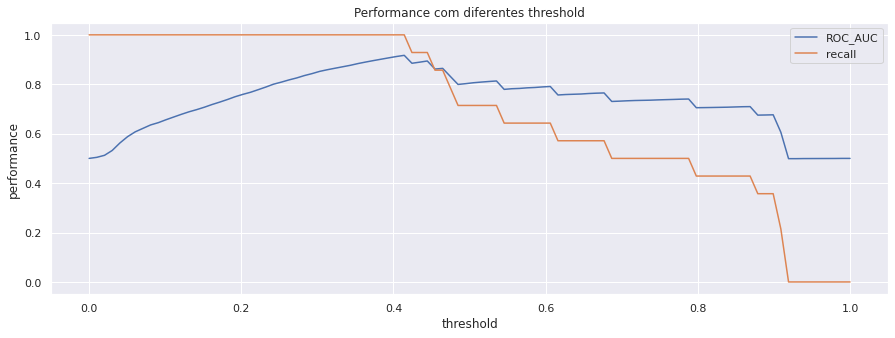

In [122]:
threshold = np.linspace(0,1,100)

n = len(threshold)

result_recall = np.zeros(n)
result_auc = np.zeros(n)

for i, t in enumerate(threshold):
  y_pred_t = ( y_prob > t ).astype('int')
  result_auc[i] = roc_auc_score(y_test, y_pred_t)
  result_recall[i] = recall_score(y_test, y_pred_t)


fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(x=threshold, y=result_auc, label='ROC_AUC')
sns.lineplot(x=threshold, y=result_recall, label='recall')

plt.title('Performance com diferentes threshold')
plt.ylabel('performance')
plt.xlabel('threshold')

plt.legend()
plt.show()

Podemos observar que o maior recall ocorre no mesmo threshold em que o AUC tem um dos melhores resultados. Vamos verificar se com esse threshold temos resultados melhor do que com o valor valor predito do sklearn.

In [123]:
best_threshold = threshold[ np.argmax(result_auc) ]
best_threshold

0.4141414141414142

In [124]:
y_pred_threshold = ( y_prob > best_threshold ).astype('int')

print('AUC pred threshold', roc_auc_score(y_test, y_pred_threshold))
print('Recall pred threshold', recall_score(y_test, y_pred_threshold))

print('\nAUC pred ', roc_auc_score(y_test, y_pred))
print('Recall pred ', recall_score(y_test, y_pred))

AUC pred threshold 0.9170979490128427
Recall pred threshold 1.0

AUC pred  0.8044305703880172
Recall pred  0.7142857142857143


Ou seja, dado uma estimativa para a probabilidade de default, definimos como default clientes com probabilidade maior que 41% de default, já que a AUC e o recall melhoraram.

## Conclusões

Obtivemos excelentes resultados para estimar a probabilidade de que o cliente não quite sua dívida. O modelo de regressão logistica foi o que nos resultou a melhor performance. O desvio padrão do pagamento esperado em alguns intervalos de tempo não teve importância no modelo e foi retirado para diminuir a complexidade e para que o modelo não degrade ao longo do tempo. Já a porcentagem de dias sem transação entro o dia 30 e o dia 90 do contrato, e a porcentagem de pagamento do empresntimo até o dia 90 do contrato foram variáveis que tiveram bastante importância para a classificação.

## Submission

Para o a entrega final, utilizaremos o modelo de Regressão Logistica com os melhores resultados.

In [125]:
dataset_submission = pd.read_parquet(train_path)
df_submission = feature_engineering(dataset_submission)
X_sub, y_sub = preprocessing(df_submission)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


O modelo será retreinado nos dados completos para obter uma previsão dos dados mais recentes.

In [126]:
df_train = feature_engineering(dataset)
X, y = preprocessing(df_train)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


In [127]:
pipeline_linreg = Pipeline([('Scaler', StandardScaler()),
                            ('Logistic Regression', LogisticRegression(penalty='l2', class_weight='balaced', C=0.001))])

pipeline_linreg.fit(X[important_features], y)

y_prob = pipeline_linreg.predict_proba(X_sub[important_features])[:,1]
y_pred = (y_prob > best_threshold).astype('int')

In [128]:
submission = pd.DataFrame({
    'id':X.index,
    'ypred':y_pred,
    'yprob':y_prob
})

#submission
submission.to_csv('submission.parquet', index=False)